In [3]:
#AUTHORS: Nithin Prasad, Murtadha Nisyif, Arpit Vaghela

### Class and Library Imports [FUNCTIONAL]
import sklearn #Scikit Learn

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from pandas import read_csv
from pandas import DataFrame

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, classification_report
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SequentialFeatureSelector

from imblearn.over_sampling import SMOTE

import random

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [4]:
### Data Exploration with the 28x28 image csv [FUNCTIONAL]

print("Hello")
project_df = pd.read_csv('data/hmnist_28_28_L.csv')
project_df.head(n=4)
print(project_df.info())

Hello
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Columns: 785 entries, pixel0000 to label
dtypes: int64(785)
memory usage: 60.0 MB
None


In [5]:
### Check Dataset Balance [FUNCTIONAL]
pixel_features = []
for i in range(784):
    str_i = str(i)
    len_suffix = len(str_i)
    pixel_feature = "pixel" + "0"*(4-len_suffix) + str_i
    #print(pixel_name)
    pixel_features.append(pixel_feature)

#X = project_df.drop('label', axis = 1)
Y = project_df['label']

#Double check the number of Labels in set
def check_set_balance(inp_set):
    val_counts = inp_set.value_counts()
    total_labels = 0
    #print(type(val_counts))
    for i in range(7):
        num_i = val_counts[i]
        print("Number of labels of class",i,":",num_i)
        total_labels += num_i
        
    print("Total number of labels:",total_labels)

print('----- LABEL CHECK -----')
check_set_balance(Y)

----- LABEL CHECK -----
Number of labels of class 0 : 327
Number of labels of class 1 : 514
Number of labels of class 2 : 1099
Number of labels of class 3 : 115
Number of labels of class 4 : 6705
Number of labels of class 5 : 142
Number of labels of class 6 : 1113
Total number of labels: 10015


785
<class 'list'>
[20, 24, 76, 131, 156, 169, 175, 185, 194, 190, 191, 190, 192, 186, 187, 188, 189, 184, 185, 180, 173, 136, 98, 59, 53, 56, 44, 30, 16, 49, 110, 156, 171, 168, 177, 189, 195, 197, 196, 194, 184, 189, 186, 187, 185, 181, 183, 193, 192, 166, 135, 83, 48, 55, 49, 34, 25, 87, 142, 175, 183, 173, 178, 191, 197, 205, 195, 175, 166, 168, 184, 178, 181, 184, 183, 195, 191, 183, 160, 112, 56, 47, 51, 39, 47, 116, 161, 184, 190, 185, 195, 190, 181, 197, 179, 167, 166, 163, 171, 170, 169, 170, 181, 192, 188, 187, 165, 136, 80, 44, 49, 42, 83, 138, 174, 188, 196, 190, 194, 178, 169, 171, 171, 175, 167, 165, 163, 164, 155, 161, 176, 186, 190, 178, 171, 154, 110, 51, 44, 44, 113, 157, 179, 191, 192, 197, 187, 168, 176, 176, 176, 179, 172, 161, 163, 163, 159, 162, 176, 179, 185, 178, 177, 175, 136, 69, 38, 43, 134, 165, 180, 187, 197, 191, 188, 170, 175, 176, 174, 180, 183, 167, 166, 175, 167, 164, 179, 185, 182, 189, 196, 189, 153, 86, 37, 39, 148, 171, 178, 190, 202, 197, 194, 17

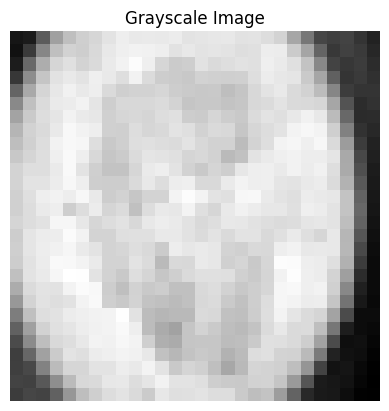

In [6]:
### Get and Display a sample row of the data [DEMO]
project_df.loc[project_df['label'] == 0]
sample_image_vec = list(project_df.iloc[9687])
print(len(sample_image_vec))
print(type(sample_image_vec))
print(sample_image_vec)
sample_image_vec.pop(-1)
print(sample_image_vec)
sample_image_vec = np.array(sample_image_vec)
sample_image = np.reshape(sample_image_vec,(28,28))
#print(sample_image)
plt.imshow(sample_image,cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

In [9]:
### Employ a pseudo-balancing of the data.
### Uses all of Class 3 (115 images), Class 5 (142 images) and only 327 random images from classes [0,1,2,4,6].

row_indices = []

for label_i in range(7):
    # Find all the rows of the dataframe corresponding to label i
    rows_of_i = project_df.loc[project_df['label'] == label_i]
    indices_of_i = list(rows_of_i.index)
    indices_of_i_random = random.sample(indices_of_i,min(327,len(rows_of_i)))

    row_indices.extend(indices_of_i_random)

row_indices.sort()

print(len(row_indices)) #Should print 1892.

working_df = project_df.iloc[row_indices]
print(working_df.info())
# print(working_df.head(n=5))

### save the working df as a csv file
# working_df.to_csv("./data/skin_cancer_dataset.csv", index=False)

1892
<class 'pandas.core.frame.DataFrame'>
Index: 1892 entries, 0 to 10014
Columns: 785 entries, pixel0000 to label
dtypes: int64(785)
memory usage: 11.3 MB
None


In [11]:
### Do Train-Validation-Test Split on the Data (eg. 60/20/20)

#read csv
df = pd.read_csv('./data/skin_cancer_dataset.csv')

#separate the features and labels
X = df.drop(columns=['label'])
y = df['label']

#split 60-40 for training dataset and a temp dataset that will be split to 50-50
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Second split of the temporary set: 50% for validation and 50% for test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#sanity check
sizes = (len(X_train), len(X_val), len(X_test))
sizes

(1135, 378, 379)

In [20]:
### Apply PCA (fit the PCA matrix using ONLY the training portion of the dataset). Transform each separately
from sklearn.decomposition import PCA

# fit pca on the training set only
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)

#sanity check
X_train_pca.shape

(1135, 56)

In [ ]:
### Implement MLP

In [ ]:
### Execute MLP Model and Print Metrics